## Product analytics
**We have data from Yandex Billboard which is a service to purchase tickets to cinemas, theathers, concerts and etc. We have to calculate basic product metrics, visualize them and come up with ideas on how to optimize marketing expenses.**



The data are from June 2017 to the end of May 2018 and they include:
- server log regarding visits to the website,
- orders from the period,
- marketing costs 


*We need to find out:* 
- how do people use our product in terms of timing (MAU, DAU, monthly dinamycs),
- when do they start buying (meaning what is the average delta from the first visit to the first purchase),
- how often do people return,
- how much income does a customer bring us,
- how efficient is our marketing

<p>&nbsp;</p>

## Step 1. Let's load take a look at the data and preprocess it (if needed)


*P.S. The currency used in the data is Russian Ruble* 

In [1]:
import datetime as dt
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('display.float.format', lambda x: '%.3f' %x)
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns

from IPython.core.display import display, HTML
display(HTML('<style>.container{width:75%! important;}</style>'))
from IPython.display import display, Markdown

In [2]:
# loading the data 
df_costs = pd.read_csv('costs.csv')
df_orders = pd.read_csv('orders_log.csv')
df_visits = pd.read_csv('visits_log.csv')

# let's take a look at what we are dealing with 
def print_info(df):
    df.info()
    display(df.describe())
    display(df)

for df in [df_costs, df_orders, df_visits]:
    print_info(df)
    print('')
    print('-----------------------------------------------------------')
    print('')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


,source_id,costs
count,2542.000,2542.000
mean,4.857,129.477
std,3.182,156.297
min,1.000,0.540
25%,2.000,21.945
50%,4.000,77.295
75%,9.000,170.065
max,10.000,1788.280


,source_id,dt,costs
0,1,2017-06-01,75.200
1,1,2017-06-02,62.250
2,1,2017-06-03,36.530
3,1,2017-06-04,55.000
4,1,2017-06-05,57.080
...,...,...,...
2537,10,2018-05-27,9.920
2538,10,2018-05-28,21.260
2539,10,2018-05-29,11.320
2540,10,2018-05-30,33.150



-----------------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


,Revenue,Uid
count,50415.000,50415.000
mean,5.000,9098160634289729536.000
std,21.818,5285741550834715648.000
min,0.000,313578113262317.000
25%,1.220,4533566627250599936.000
50%,2.500,9102273602618561536.000
75%,4.890,13682901980465401856.000
max,2633.280,18446167067214817280.000


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.000,10329302124590727494
1,2017-06-01 00:25:00,0.550,11627257723692907447
2,2017-06-01 00:27:00,0.370,17903680561304213844
3,2017-06-01 00:29:00,0.550,16109239769442553005
4,2017-06-01 07:58:00,0.370,14200605875248379450
...,...,...,...
50410,2018-05-31 23:50:00,4.640,12296626599487328624
50411,2018-05-31 23:50:00,5.800,11369640365507475976
50412,2018-05-31 23:54:00,0.300,1786462140797698849
50413,2018-05-31 23:56:00,3.670,3993697860786194247



-----------------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


,Source Id,Uid
count,359400.000,359400.000
mean,3.751,9202556994354921472.000
std,1.917,5298432824659611648.000
min,1.000,11863502262781.000
25%,3.000,4613406732167550976.000
50%,4.000,9227412908740601856.000
75%,5.000,13728237011236173824.000
max,10.000,18446676030785673216.000


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485



-----------------------------------------------------------



### Description of the data
<p>&nbsp;</p>

*The table **df_visits** (server log with visits):*
- Uid — unique id of a user
- Device — device kind (mobile or web)
- Start Ts — date and time of the beggining of the session 
- End Ts — date and time of the end of the sessions
- Source Id — marketing channel id, from which a user came

<p>&nbsp;</p>

*The table **df_orders** (information about purchases):*
- Uid — id of a user who made a purchase
- Buy Ts — date and time of a purchase
- Revenue — revenue from a purchase

<p>&nbsp;</p>

*The table **df_costs** (information about marketing costs):*
- source_id — id of a marketing channel
- dt — date 
- costs — marketing costs per sourse on a given day

In [3]:
# let's also notice that some of our columns are written with capital letters 
for df in [df_costs, df_orders, df_visits]:
    print(df.columns.to_list())

['source_id', 'dt', 'costs']
['Buy Ts', 'Revenue', 'Uid']
['Device', 'End Ts', 'Source Id', 'Start Ts', 'Uid']


### We have several inaccuracies in our data: 
1. uninformative names of columns 
2. absence of lower dashes in column names
3. capital lettes in column names
4. wrong data types in columns with dates 

In [4]:
# let's make the column names lowercase 
for df in [df_costs, df_orders, df_visits]:
    df.columns = map(str.lower, df.columns)
    
# renaming columns    
df_costs = df_costs.rename({'dt':'dt_of_commercial', 'costs':'cost_for_marketing_source'}, 
                           axis='columns')
df_orders = df_orders.rename({'buy ts':'dt_of_order'}, axis='columns')
df_visits = df_visits.rename({'device':'device_cat', 'start ts':'dt_start_of_session',
                              'end ts':'dt_end_of_session', 'source id': 
                              'commercial_source_id'}, 
                             axis = 'columns')

# checking results
for df in [df_costs, df_orders, df_visits]:
    display(df.columns.to_list())

['source_id', 'dt_of_commercial', 'cost_for_marketing_source']

['dt_of_order', 'revenue', 'uid']

['device_cat',
 'dt_end_of_session',
 'commercial_source_id',
 'dt_start_of_session',
 'uid']

In [5]:
# converting dates to datetime64 and extracting days, weeks, months and years
def make_date_and_add_columns(df, column_name, 
                              date_column_name, week_column_name, 
                              month_column_name, year_column_name):
    '''
        writing a function, which adds days, weeks, months and years
    '''
    df = df.copy()
    df[column_name] = pd.to_datetime(df[column_name])
    df[date_column_name] = df[column_name].astype('datetime64[D]')
    df[week_column_name] = df[column_name].astype('datetime64[W]')
    df[month_column_name] = df[column_name].astype('datetime64[M]')
    df[year_column_name] = df[column_name].astype('datetime64[Y]')
    return df

# applying the function to df_costs   
df_costs = df_costs.pipe(make_date_and_add_columns, 'dt_of_commercial', 
                         'day_of_commercial','week_of_commercial', 
                         'month_of_commercial', 'year_of_commercial')

# we're not sure yet that we need so many columns in other dataframes, so for the other two
# dfs let's only change the data type

def transform_into_date_type(df, columns):
    """transfoorming a column to a datetime64 format"""
    df = df.copy()
    for col in columns: 
        df[col] = pd.to_datetime(df[col])
    return df

# applying it 

df_costs = transform_into_date_type(df_costs, ['dt_of_commercial'])
df_orders = transform_into_date_type(df_orders, ['dt_of_order'])
df_visits = transform_into_date_type(df_visits, ['dt_end_of_session'])

In [6]:
# let's check data for missing values and duplicates 
names = {'df_visits': df_visits, 'df_costs': df_costs, 'df_orders': df_orders}
for name, df in names.items():
    print('The number of duplicates in', name, df.duplicated().sum())
    for column in df.columns: 
        print('The number of duplicates in', column, ':', df[column].isna().sum())

The number of duplicates in df_visits 0
The number of duplicates in device_cat : 0
The number of duplicates in dt_end_of_session : 0
The number of duplicates in commercial_source_id : 0
The number of duplicates in dt_start_of_session : 0
The number of duplicates in uid : 0
The number of duplicates in df_costs 0
The number of duplicates in source_id : 0
The number of duplicates in dt_of_commercial : 0
The number of duplicates in cost_for_marketing_source : 0
The number of duplicates in day_of_commercial : 0
The number of duplicates in week_of_commercial : 0
The number of duplicates in month_of_commercial : 0
The number of duplicates in year_of_commercial : 0
The number of duplicates in df_orders 0
The number of duplicates in dt_of_order : 0
The number of duplicates in revenue : 0
The number of duplicates in uid : 0


**Great! Our data does not duplicates nor missing values. We are set to research.**

In [7]:
# let's make one final check if all of the functions executed
for df in [df_costs, df_orders, df_visits]:
    print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 7 columns):
source_id                    2542 non-null int64
dt_of_commercial             2542 non-null datetime64[ns]
cost_for_marketing_source    2542 non-null float64
day_of_commercial            2542 non-null datetime64[ns]
week_of_commercial           2542 non-null datetime64[ns]
month_of_commercial          2542 non-null datetime64[ns]
year_of_commercial           2542 non-null datetime64[ns]
dtypes: datetime64[ns](5), float64(1), int64(1)
memory usage: 139.1 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
dt_of_order    50415 non-null datetime64[ns]
revenue        50415 non-null float64
uid            50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device_cat     

**All good. Let's move to calculating product metrics** 

## Step 2. 

Calculating product metrics and answering the following questions: 
- How many people use the product daily, monthly, weekly?
- How many sessions per user a day?
- How long is one session (on average)?
- How often do people come back (retention)?

<p>&nbsp;</p>

*Also: the are two kinds of devices (mobile/web), and various types of marketing sources. We will calculate different metrics mostly for: device_category + marketing_channel*


-----------------------------------------------------------------------------------------------------------
Percentage of users, using mobile or/and desktop versions:


desktop   0.731
touch     0.269
Name: device_cat, dtype: float64


-----------------------------------------------------------------------------------------------------------
There are 228169 unique users

-----------------------------------------------------------------------------------------------------------
The earliest session is on the: 2017-06-01 00:01:00 , the latest is on 2018-05-31 23:59:00

-----------------------------------------------------------------------------------------------------------
There are 9 marketing channels and 7 of them are paid


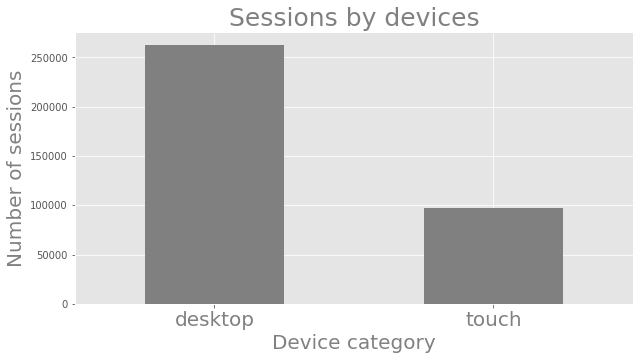

In [8]:
# Calculating engagement metrics and visualizing them
# let's set the style for matplotlib 
plt.style.use('ggplot')

# let's count the ration of sessions by device category
df_visits['device_cat'].value_counts().plot(
                                            kind='bar', figsize=(10,5), 
                                            grid=True, color='grey'
)
plt.title('Sessions by devices', fontsize=25, color='grey')
plt.xlabel('Device category', fontsize=20, color='grey')
plt.ylabel('Number of sessions', fontsize=20, color='grey')
plt.xticks(rotation=0, fontsize=20, color='grey')

print('------------------------------------------\
-----------------------------------------------------------------')
print('\033[1m' + 'Percentage of users, using mobile or/and desktop versions:' + '\033[0m' )
display(df_visits['device_cat'].value_counts(normalize = True))
print('')
print('------------------------------------------\
-----------------------------------------------------------------')
print('\033[1m' + 'There are', df_visits['uid'].nunique(), 
      'unique users' + '\033[0m' )

print('')
print('------------------------------------------\
-----------------------------------------------------------------')
print('\033[1m' + 'The earliest session is on the:' + 
      '\033[0m' , df_visits['dt_start_of_session'].\
      min(),',','\033[1m' + 'the latest is on' + '\033[0m' , 
      df_visits['dt_start_of_session'].max())

print('')
print('------------------------------------------\
-----------------------------------------------------------------')
df_visits['commercial_source_id'].value_counts()
print('\033[1m' + 'There are', df_visits['commercial_source_id'].\
      nunique(),
      'marketing channels and', df_costs['source_id'].nunique(), 
      'of them are paid' + '\033[0m' )

*It's clear that **desktop version is more popular than mobile**. It has **73%** of visits, meanwhile the mobile version has only **27%.** Let's also check for intersection to find users who use both kind of devices.

In [9]:
# creating two sets and checking for intersection 
touch_users = df_visits.query('device_cat == "touch"')
desktop_users = df_visits.query('device_cat == "desktop"')
touch_set = set(touch_users['uid'])
desktop_set = set(desktop_users['uid'])

result = []
for uid in touch_set: 
    if uid in desktop_set: 
        result.append(uid) 
        
percent_of_users_who_use_both_platforms = len(result) / len(df_visits) 
print('\033[1m' + 'Percentage of users who use both mobile and web versions: \
{:.1%}'.\
      format(percent_of_users_who_use_both_platforms))

Percentage of users who use both mobile and web versions: 2.1%


Only **2%** of people use both platforms. Consequently, it seems reasonable to divide people on web and mobile users. 

# How many people use the product daily, weekly, monthly?

In [10]:
# let's also convert the dataframe with visits to datetime64 and extract days, weeks, months
# and yearas
df_visits = df_visits.pipe(
                           make_date_and_add_columns, 'dt_start_of_session', 
                           'dt_start_of_session_day','dt_start_of_session_week', 
                           'dt_start_of_session_month', 'dt_start_of_session_year'
)

# calculating User Engagement Metrics
dau_total = df_visits.groupby('dt_start_of_session_day').\
agg({'uid':'nunique'}).mean().astype(int)
wau_total = df_visits.groupby(['dt_start_of_session_year', 
                               'dt_start_of_session_week']).\
agg({'uid':'nunique'}).mean().astype(int)
mau_total = df_visits.groupby(['dt_start_of_session_year', 
                               'dt_start_of_session_month']).\
agg({'uid':'nunique'}).mean().astype(int)

# for handy demonstration of the information let's create a dictionary and use a loop 

sticky_metrics = {'DAU': dau_total, 'WAU':wau_total, 
                  'MAU':mau_total}
for name,metric in sticky_metrics.items():
    print('\033[1m' + name + '\033[0m',':', int(metric), 'unique users')

# calculating 'stickness ratio'
sticky_wau = dau_total / wau_total * 100
sticky_mau = wau_total/mau_total * 100
print('\033[1m' + 'DAU / WAU =', 
      int(sticky_wau), '%'+ '\033[0m')
print('\033[1m' + 'WAU / MAU =', 
      int(sticky_mau), '%' + '\033[0m')

DAU : 907 unique users
WAU : 5621 unique users
MAU : 23228 unique users
DAU / WAU = 16 %
WAU / MAU = 24 %


We calculated the stickness of our product. To sum up, **Yandex Afisha has a small number of frequent users, but most of them tend not to come back**. Now let's take a look at dynamic of these metrics. 

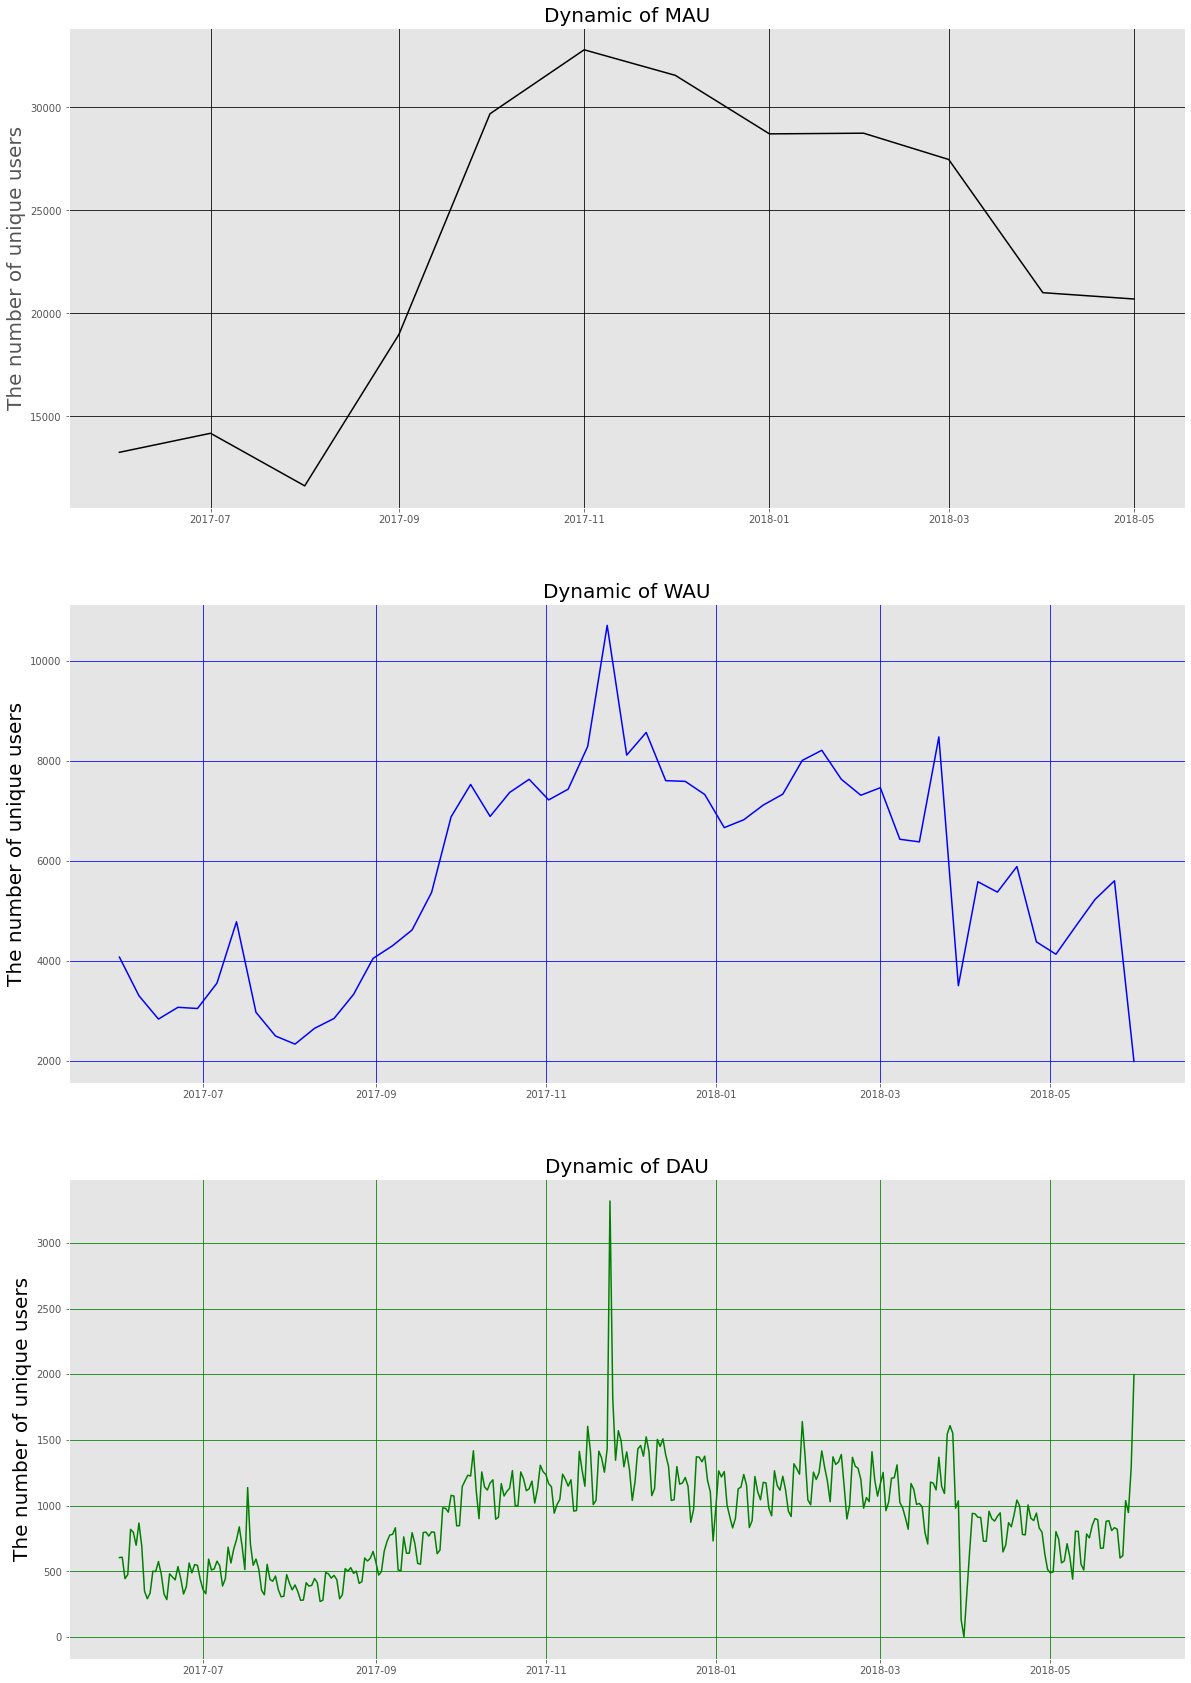

In [11]:
# visualizing DAU, WAU, MAU
fig,ax = plt.subplots(3,1, figsize=(20, 30))
ax[0].plot(df_visits.groupby('dt_start_of_session_month').\
           agg({'uid':'nunique'}), color='black')
# the first subplot for months 
ax[0].set_ylabel('The number of unique users', fontsize=20)
ax[0].set_title('Dynamic of MAU', fontsize=20, color='black')
ax[0].grid(color='black')

# the second one for weeks
ax[1].plot(df_visits.groupby('dt_start_of_session_week').\
           agg({'uid':'nunique'}), color='b')
ax[1].set_ylabel('The number of unique users', fontsize=20, color='black')
ax[1].set_title('Dynamic of WAU', fontsize=20, color='black')
ax[1].grid(color='blue')

# the third one for days
ax[2].plot(df_visits.groupby('dt_start_of_session_day').\
           agg({'uid': 'nunique'}), color='g')
ax[2].set_ylabel('The number of unique users', fontsize=20, color='black')
ax[2].set_title('Dynamic of DAU', fontsize=20, color='black')
ax[2].grid(color='green')
plt.show()

It is clear that **the busiest months for the product were November and December of 2017. For the rest of the time the metrics kept approximately steady. There was one major drop around the end of March/beginning of April**

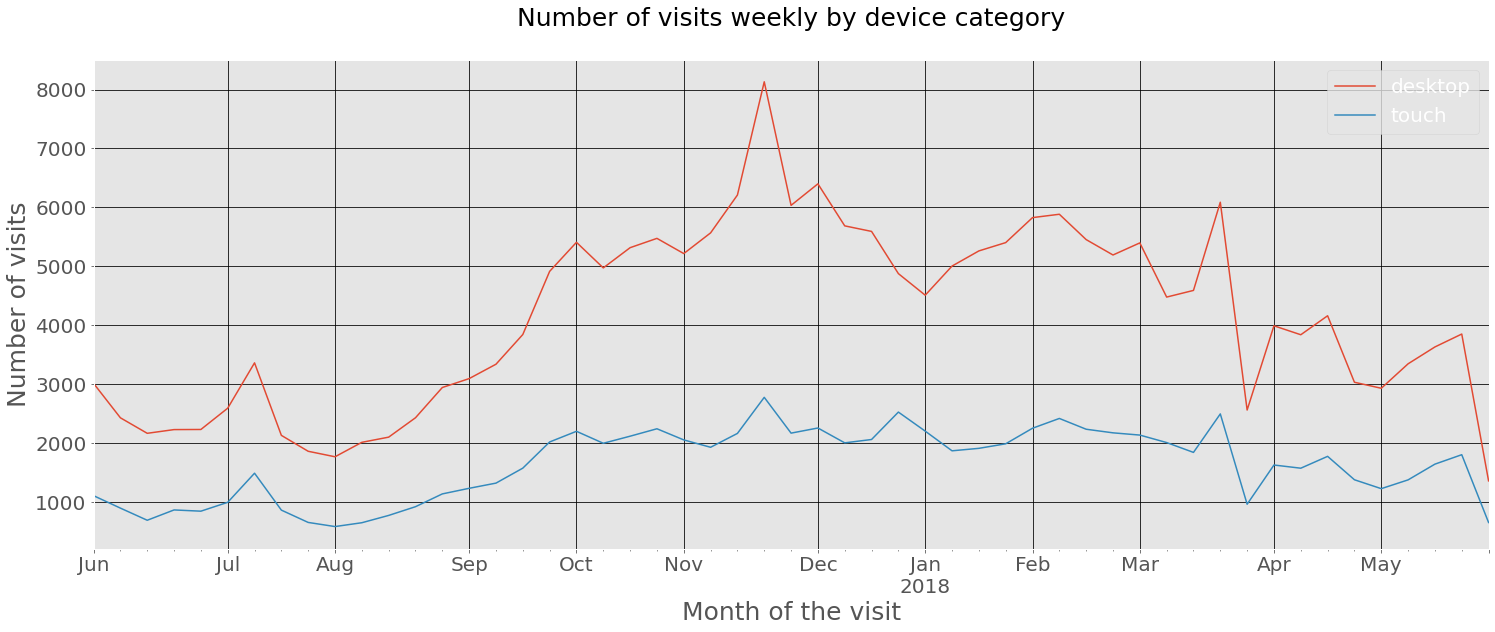

In [12]:
# let's see how visits are distributed by device categories
df_visits.pivot_table(
                             index='dt_start_of_session_week', values='uid', 
                             columns='device_cat', aggfunc='nunique'
).\
plot(figsize = (25, 9))
plt.title('Number of visits weekly by device category' + '\n', fontsize = 25, color='black')
plt.legend(prop={'size': 20})
plt.ylabel('Number of visits', fontsize = 25)
plt.xlabel('Month of the visit', fontsize = 25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.grid(c='black')
plt.show()


There is no surprise that there are way more users using the product from desktop. As it's calculated earlier, 3/4 of the users use the desktop version. 

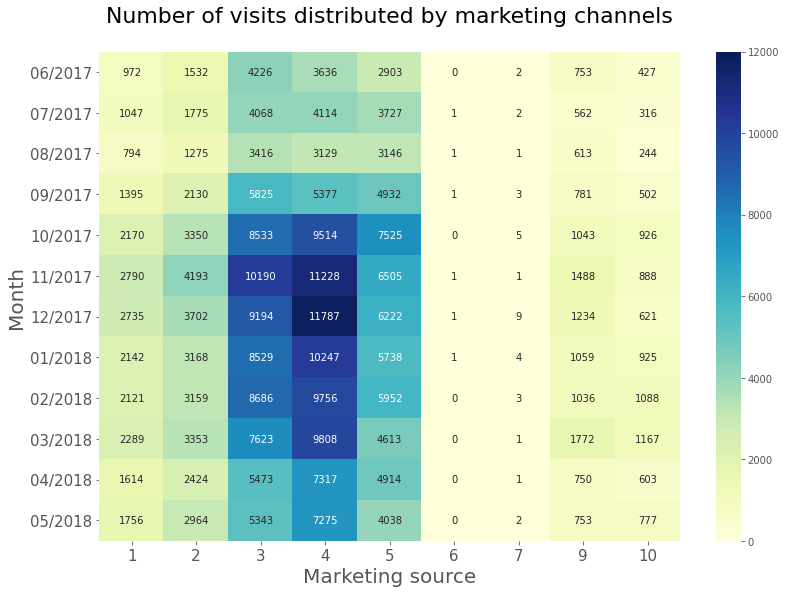

In [13]:
# analyzing umarketing channels. Let's count how many unique users came from each 
# marketing channel
mau_pivot = df_visits.pivot_table(
                                  index='dt_start_of_session_month', values='uid',
                                  columns='commercial_source_id', aggfunc='nunique'
).\
fillna(0).astype(int)

# using heatmap
plt.figure(figsize=(13,9))
mau_pivot_with_index = mau_pivot.copy()
mau_pivot_with_index.index = mau_pivot_with_index.index.strftime('%m/%Y')
sns.heatmap(mau_pivot_with_index, cmap="YlGnBu", annot=True, vmin=0,
            vmax=12000, fmt='d')
plt.title('Number of visits distributed by marketing channels' + '\n', 
          fontsize=22, color='black')
plt.ylabel('Month', fontsize=20)
plt.xlabel('Marketing source', fontsize=20)
plt.yticks( fontsize = 15, rotation=0)
plt.xticks(fontsize = 15)
plt.show()

The biggest number of potential clients come from the third and the forth marketing channels. Another insight which could be taken from this graph is that the number of users fluctuates by seasons. The highest number of visitors came in November and December. 

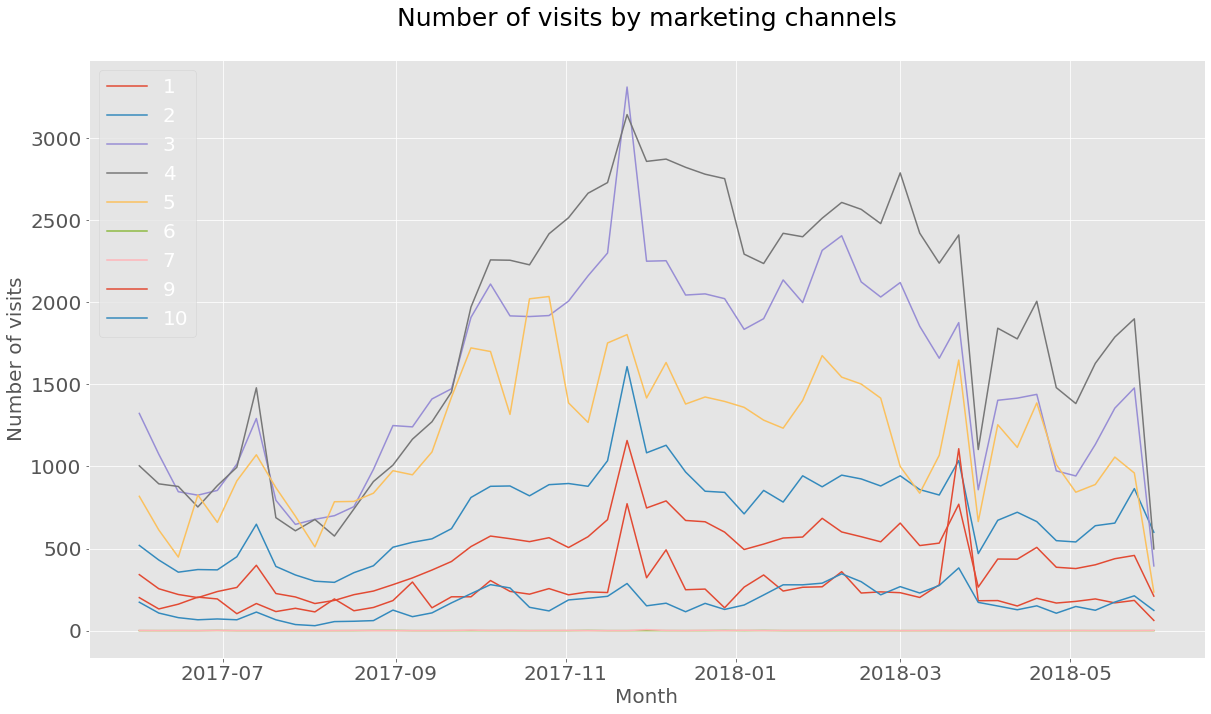

In [14]:
# visualizing the dynamic 
plt.style.use('ggplot')
wau_pivot = df_visits.pivot_table(
                                  index='dt_start_of_session_week', values='uid', 
                                  columns='commercial_source_id', aggfunc='nunique'
).\
fillna(0).astype(int)

plt.figure(figsize=(20,11))
plt.grid(True)
plt.title('Number of visits by marketing channels' + '\n', 
          fontsize = 25, color='black')
plt.plot(wau_pivot)
plt.legend(wau_pivot.columns, loc=0, prop={'size': 20})
plt.xlabel('Month', fontsize=20)
plt.ylabel('Number of visits', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

## To sum up:
- the time searies has seasonality, November and December are the most lucrative months 
- the biggest number of leads comes from 3rd and 4th marketing channels
- the number of frequent users is somewhat small compared to the total number of users

# How many sessions are there per day?

In [15]:
# calculating the number of sessions per user  
def count_sessions_per_day(df):
    '''Calculates the number of sessions per day, 
    displays 'describe'
    '''
    print('Statistics on the number of sessions per day:')
    display(round(df.groupby(['dt_start_of_session_year', 
                              'dt_start_of_session_day']).agg({'uid':'count'})\
                  .describe()))
    print('An average users have {:.2f} sessions per day'.\
          format(df.groupby(['dt_start_of_session_year', 
                             'dt_start_of_session_day'])['uid'].count().mean() / 
                df.groupby(['dt_start_of_session_year', 
                            'dt_start_of_session_day'])['uid'].nunique().mean()))

In [16]:
for device in ['desktop', 'touch']:
    print('\033[1m' + device + '\033[0m')
    count_sessions_per_day(df_visits.query('device_cat==@device'))

desktop
Statistics on the number of sessions per day:


,uid
count,364.000
mean,721.000
std,322.000
min,1.000
25%,457.000
50%,711.000
75%,962.000
max,3152.000


An average users have 1.09 sessions per day
touch
Statistics on the number of sessions per day:


,uid
count,363.000
mean,267.000
std,111.000
min,47.000
25%,181.000
50%,278.000
75%,337.000
max,890.000


An average users have 1.05 sessions per day


## To sum up:

On average **users have one session per day**. The number is slightly higher for the desktop version. 

# How long is a typical session?

In [17]:
# When we first displayed the describe function it was clear that there were several sessions
# with the length of 19 seconds. It does not seem plausible, so let's round them to 1 minute 

df_visits['dt_start_of_session'] = pd.to_datetime(df_visits['dt_start_of_session'])
df_visits['dt_start_of_session'] = df_visits['dt_start_of_session'].dt.ceil('1T')
df_visits['dt_end_of_session'] = df_visits['dt_end_of_session'].dt.ceil('1T')

# to begin, let's check for any mistakes in data and see if we have any negative values
df_visits['session_length_seconds_total'] = (df_visits['dt_end_of_session'] - 
                                             df_visits['dt_start_of_session']).\
dt.total_seconds()
display(df_visits['session_length_seconds_total'].describe())

count   359400.000
mean       643.125
std        997.068
min      -2760.000
25%        120.000
50%        300.000
75%        840.000
max      42660.000
Name: session_length_seconds_total, dtype: float64

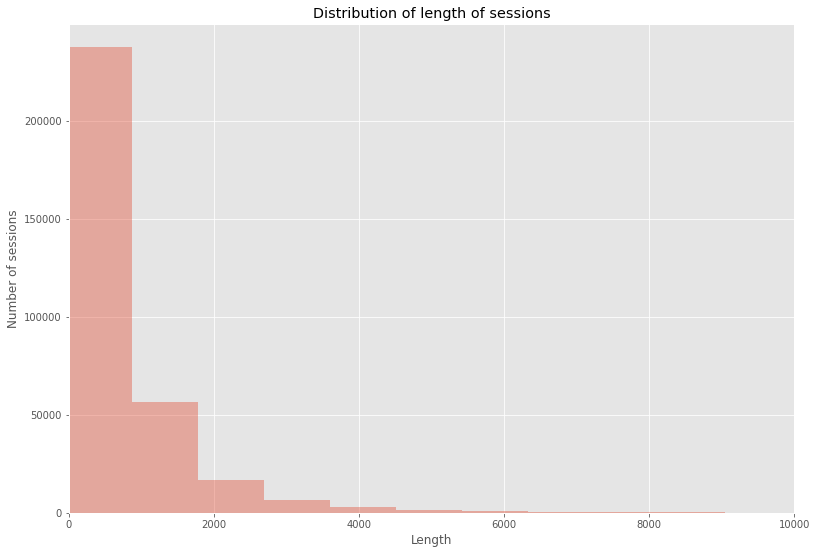

2

0

Mode is 60 seconds
count   323606.000
mean       714.290
std       1026.282
min         60.000
25%        120.000
50%        360.000
75%        900.000
max      42660.000
Name: session_length_seconds_total, dtype: float64


In [18]:
# there are several zeros in the dataframe. Presumably it could be explained by 
# browser extensions or by flaws in data collection 
# We can't take insightful information from zeros, so let's get rid of them and check the 
# distribution
session_length_no_zeros = df_visits.query('session_length_seconds_total != 0')
plt.figure(figsize=(13,9))
sns.distplot(session_length_no_zeros['session_length_seconds_total'], kde=False)
plt.xlim(0, 10000)
plt.title('Distribution of length of sessions', c='black')
plt.xlabel('Length')
plt.ylabel('Number of sessions')
plt.show()

# Moreover, there is -2760. Let's check for negative values 
display(session_length_no_zeros['session_length_seconds_total']\
            [session_length_no_zeros['session_length_seconds_total'] < 0].count())

# we have two negative values. Let's use abs()
session_length_no_zeros['session_length_seconds_total'] = \
session_length_no_zeros['session_length_seconds_total'].abs()
display(session_length_no_zeros['session_length_seconds_total']\
        [session_length_no_zeros['session_length_seconds_total'] < 0].count())

# the distribution seems to be far from normal, consequently the representative measure 
# of the central tendency would either be median or mode

print('Mode is', int(
    session_length_no_zeros['session_length_seconds_total'].\
    mode().round(2)), 'seconds')
print(session_length_no_zeros['session_length_seconds_total'].describe())

### To sum up: 
- **the mode of the distribution is 1 minute**. Is it possible that the majority of users spend about 1 minute with the product?
- **it could be that the more representative for the central tendency of the distribution would be median which is 6 minutes** 
- well, apparently if it was real situation then one has to ask data engineers how exactly the data stored and could browser extensions or something else be responsible for the number we get

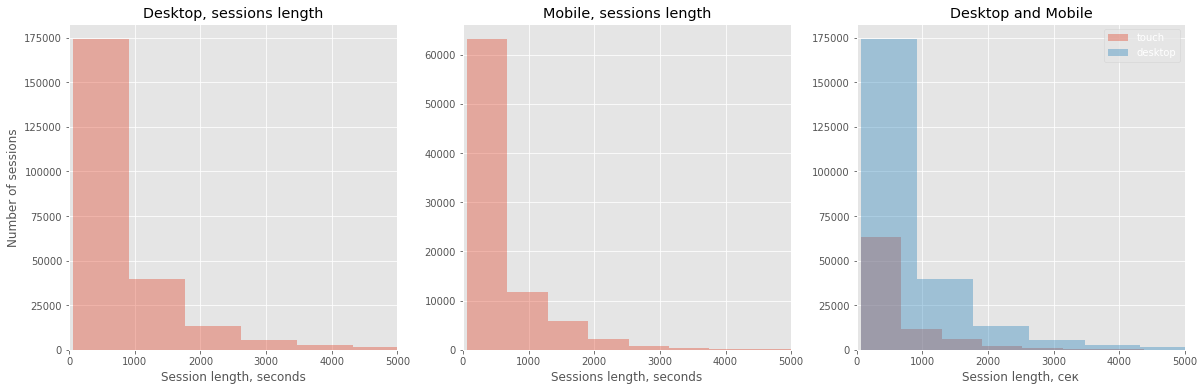

In [19]:
# visualizing the distribution of session lengths for divice categories 
session_length_no_zeros_desktop = session_length_no_zeros.query(
    'device_cat =="desktop"')
session_length_no_zeros_touch = session_length_no_zeros.query(
    'device_cat =="touch"')
names = ['Desktop, sessions length', 'Mobile, sessions length',
        'Desktop and Mobile']


# visualizing 
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(6)

sns.distplot(session_length_no_zeros_desktop['session_length_seconds_total'], 
            kde=False, ax=ax[0])
ax[0].set_xlim(0,5000)
ax[0].set_title(names[0], c='black')
ax[0].set_xlabel('Session length, seconds')
ax[0].set_ylabel('Number of sessions')

sns.distplot(session_length_no_zeros_touch['session_length_seconds_total'], 
            kde=False, ax=ax[1])
ax[1].set_xlabel('Sessions length, seconds')
ax[1].set_title(names[1], c='black')
ax[1].set_xlim(0,5000)


sns.distplot(session_length_no_zeros_touch['session_length_seconds_total'],
            kde=False, ax=ax[2], label='touch')
sns.distplot(session_length_no_zeros_desktop['session_length_seconds_total'], 
            kde=False, ax=ax[2], label='desktop')
ax[2].set_title(names[2], c='black')
ax[2].set_xlabel('Session length, сек')
ax[2].set_xlim(0,5000)
plt.legend()
plt.show()

## To sum up:

We calculated both the mode and the median. However, **we still cannot say which measure of the central tendency is more representative of us**. Most likely, there is an error in the data due to which many sessions are marked with a short duration - then the median is suitable for us. And common sense suggests that it is difficult to have time to see something in a minute, and even more so to buy on the site.

# How often do users come back? (Retention) 

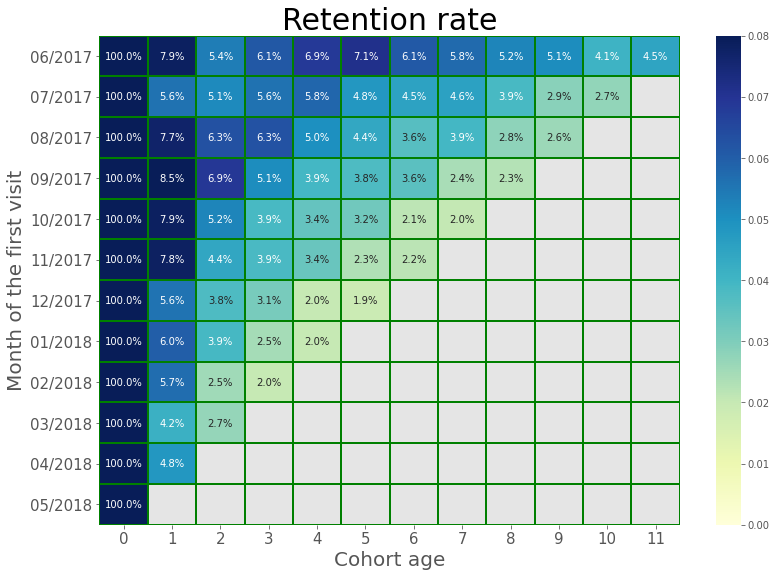

In [20]:
# calculating retention rate
def get_month(x): return dt.datetime(x.year, x.month, 1)
df_visits['visit_month'] = df_visits['dt_start_of_session'].apply(get_month)
grouping = df_visits.groupby('uid')['visit_month']
df_visits['cohort_month'] = grouping.transform('min')

def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

def count_retention(df):
    visit_year, visit_month, _ = get_date_int(df, 'visit_month')
    cohort_year, cohort_month, _ = get_date_int(df, 'cohort_month')
    year_diff = visit_year - cohort_year
    month_diff = visit_month - cohort_month
    df['cohort_index'] = year_diff * 12 + month_diff    
    grouping = df.groupby(['cohort_month', 'cohort_index'])
    cohort_data = grouping['uid'].apply(pd.Series.nunique)
    cohort_data = cohort_data.reset_index()
    cohort_counts = cohort_data.pivot_table(index='cohort_month', 
                                            columns='cohort_index', values='uid')
    cohort_sizes = cohort_counts.iloc[:, 0]
    retention = cohort_counts.divide(cohort_sizes, axis=0)
    retention.round(4) * 100
    retention.index = retention.index.strftime("%m/%Y")
    return retention

# visualizing it with a heatmap    
plt.figure(figsize=(13, 9))    
sns.heatmap(count_retention(df_visits), annot=True, fmt='.1%', linewidths=1, 
            linecolor='green', cmap="YlGnBu", vmin=0, vmax=0.08)
plt.ylabel('Month of the first visit', fontsize=20)
plt.xlabel('Cohort age', fontsize=20)
plt.title('Retention rate', fontsize=30, c='black')
plt.yticks(rotation=0, fontsize=15)
plt.xticks(fontsize=15)
plt.show()

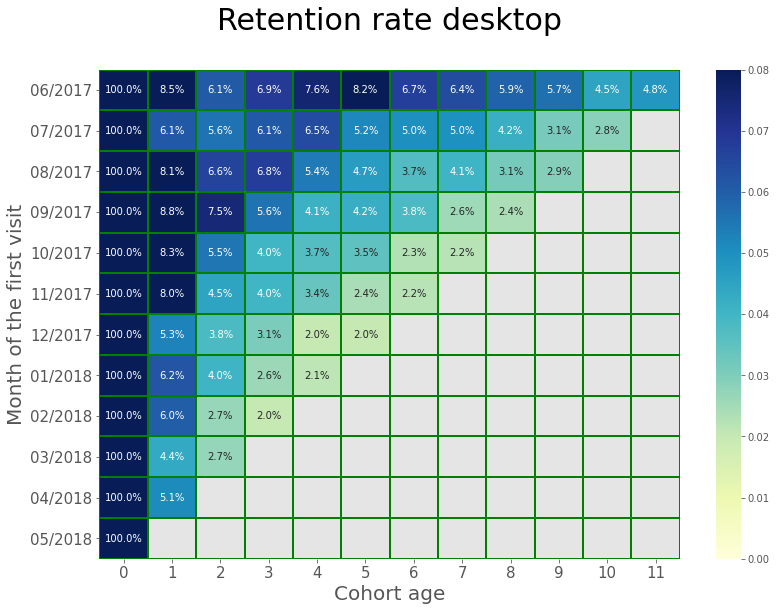

In [21]:
# calculating RR for desktop
df_visits_desktop = df_visits.query('device_cat == "desktop"')
plt.figure(figsize=(13, 9))    
sns.heatmap(count_retention(df_visits_desktop), annot=True, fmt='.1%', linewidths=1, 
            linecolor='green', cmap="YlGnBu", vmin=0, vmax=0.08)
plt.ylabel('Month of the first visit', fontsize=20)
plt.xlabel('Cohort age', fontsize=20)
plt.title('Retention rate desktop' + '\n', fontsize=30, c='black')
plt.yticks(rotation=0, fontsize=15)
plt.xticks(fontsize=15)
plt.show()

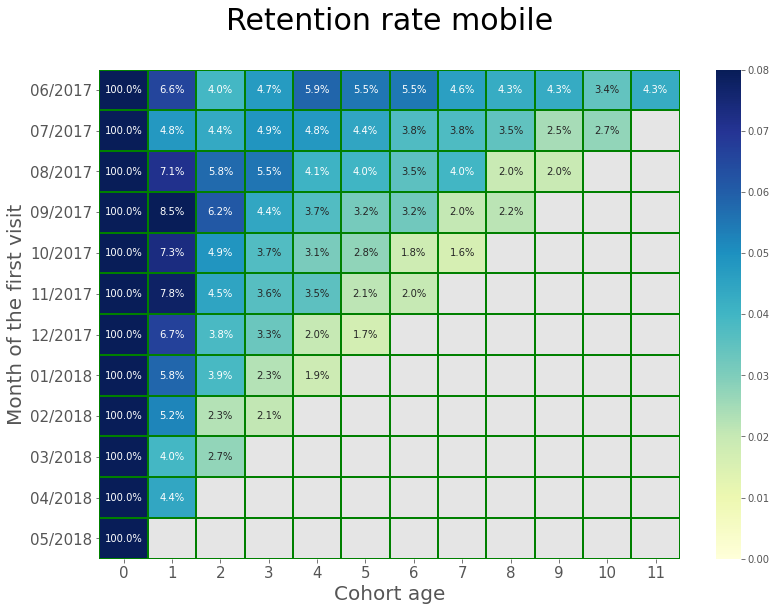

In [22]:
df_visits_touch = df_visits.query('device_cat == "touch"')
plt.figure(figsize=(13, 9))    
sns.heatmap(count_retention(df_visits_touch), annot=True, fmt='.1%', linewidths=1, 
            linecolor='green', cmap="YlGnBu", vmin=0, vmax=0.08)
plt.ylabel('Month of the first visit', fontsize=20)
plt.xlabel('Cohort age', fontsize=20)
plt.title('Retention rate mobile' + '\n', fontsize=30, c='black')
plt.yticks(rotation=0, fontsize=15)
plt.xticks(fontsize=15)
plt.show()

It is clear that RR rate of desktop is higher than of the mobile version. Let's count the exact number by which it is higher. 

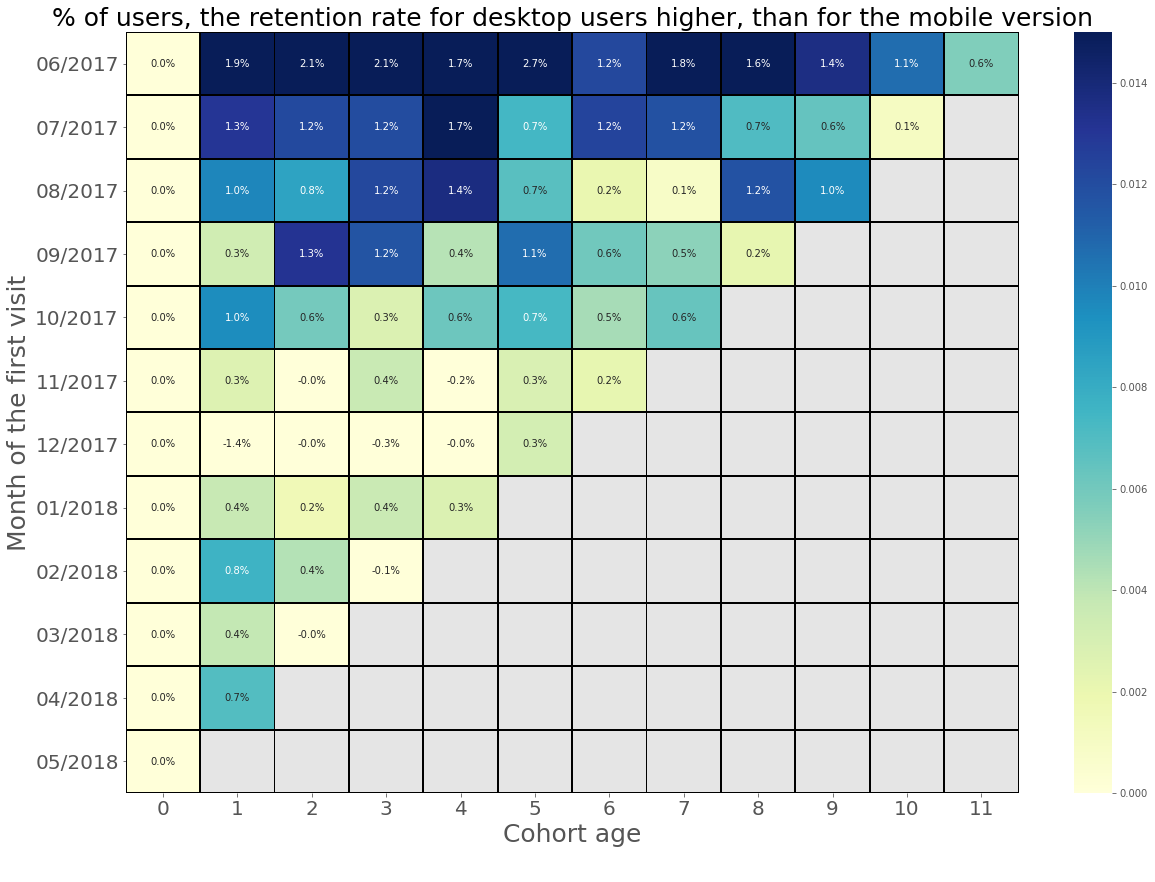

In [23]:
diff_between_retentions = count_retention(df_visits_desktop) - \
count_retention(df_visits_touch)
plt.figure(figsize=(20,14))
sns.heatmap(diff_between_retentions, annot=True, fmt='.1%', linewidth=1, 
            linecolor='black', cmap='YlGnBu', vmin=0, vmax=0.015)
plt.title('% of users, the retention rate for desktop users higher, than \
for the mobile version', 
          fontsize=25, c='black')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20, rotation=0)
plt.xlabel('Cohort age'+ '\n', fontsize=25)
plt.ylabel('Month of the first visit', fontsize=25)
plt.show()

## To sum up:
- average retention rate is 4.6%
- desktop users' retention rate is higher than mobile users' rr

# When do people start buying?

In [24]:
# let's count the number of days from the first visit to the first purchase  
first_session = df_visits.groupby('uid')['dt_start_of_session'].min()
first_session.name = 'first_session'
df_visits = df_visits.merge(first_session, on='uid')
first_visit = df_visits[['uid', 'first_session', 'device_cat', 
                         'commercial_source_id']].reset_index()
first_visit = first_visit.sort_values(by='first_session')
first_visit = first_visit.groupby('uid')[['first_session', 'device_cat', 
                                          'commercial_source_id']].\
first().reset_index()
first_purchase = df_orders.groupby('uid')['dt_of_order'].min().reset_index()
time_to_first_purchase = first_visit.merge(first_purchase, on='uid', how='right')

time_to_first_purchase['time_to_first_purchase'] = pd.to_timedelta(
    (time_to_first_purchase['dt_of_order'] - \
     time_to_first_purchase['first_session']).\
    dt.days, unit='d')/np.timedelta64(1, 'D')

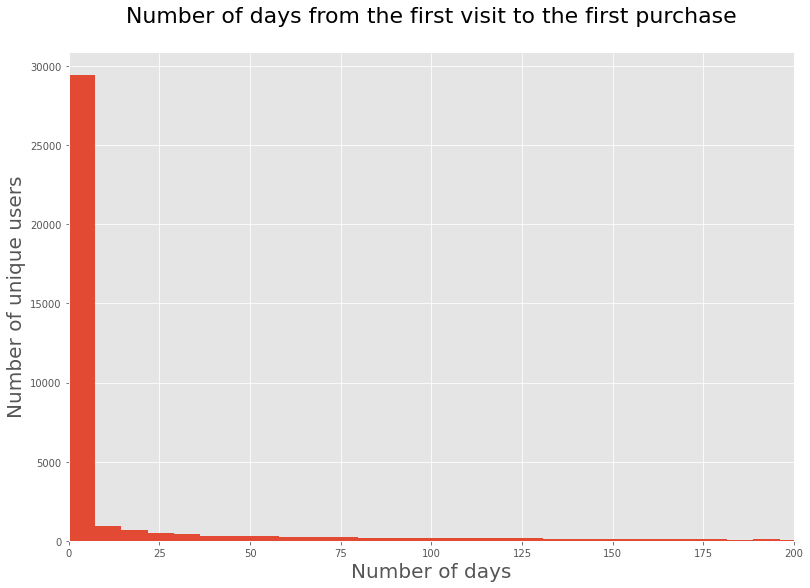

Mode for desktop and mobile is 0
Mode for desktop is 0
Mode for mobile is 0


In [25]:
# visualizing
plt.figure(figsize=(13,9))
time_to_first_purchase['time_to_first_purchase'].hist(bins=50)
plt.xlim(0,200)
plt.xlabel('Number of days',
           fontsize=20)
plt.ylabel('Number of unique users', fontsize=20)
plt.title('Number of days from the first visit to the first purchase' + '\n', 
          fontsize=22, color='black')
plt.show()
# посмотрим, какая мода у этой метрики по категории устройств
print('Mode for desktop and mobile is', 
      int(time_to_first_purchase['time_to_first_purchase'].mode()))
time_to_first_purchase_desktop = time_to_first_purchase.query(
    'device_cat == "desktop"')
print('Mode for desktop is',
      int(time_to_first_purchase_desktop['time_to_first_purchase'].mode()))
time_to_first_purchase_touch = time_to_first_purchase.query(
    'device_cat == "touch"')
print('Mode for mobile is',
      int(time_to_first_purchase_touch['time_to_first_purchase'].mode()))

**It is shown on the graph that the majority of users buy on the first day they visit. There is a way to check this. We need to count the cumulative sum of all the session and see the percentage of users who only have one session. If it is the majority, then we don't have to be suspicious that the mode is 0.**

In [26]:
df_visits['num_of_session'] = df_visits.sort_values(
    ['uid','dt_start_of_session'], ascending=[True,True]) \
             .groupby(['uid']) \
             .cumcount() + 1
df_visits.sort_values(by=['uid', 'num_of_session'])
df_visits['num_of_session'].value_counts(normalize=True).head(10)

1    0.635
2    0.145
3    0.059
4    0.031
5    0.019
6    0.012
7    0.009
8    0.006
9    0.005
10   0.004
Name: num_of_session, dtype: float64

## To sum up:

The distribution of the sum of the number of sessions by users suggests that 63.5 percent of users pay our product just one visit.
Accordingly, people on average start buying on the first day on the site.

# How many purchases are there per month?

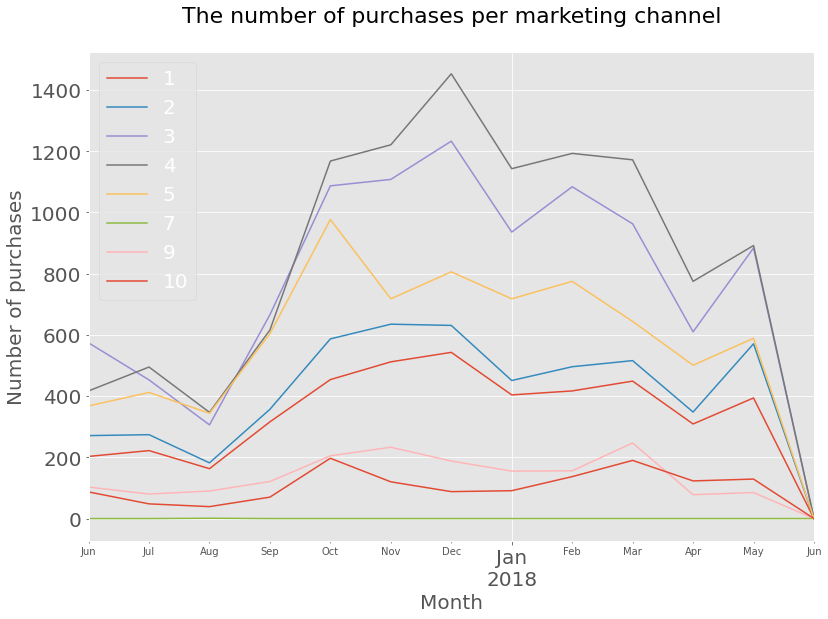

In [27]:
# calculating the number of purchases per marketing channel
first_source = df_visits.groupby(['uid'])[['commercial_source_id', 
                                           'device_cat']].first()
purchases = df_orders.merge(first_source, on='uid',
                        how='left')

purchases['order_month'] = purchases['dt_of_order'].\
astype('datetime64[M]')
purchases.pivot_table(index='order_month', values='uid', 
                                 columns='commercial_source_id', 
                                 aggfunc='nunique').\
fillna(0).astype(int).plot(figsize=(13,9))
plt.title('The number of purchases per marketing channel' + '\n', 
          fontsize=22, c='black')
plt.xlabel('Month', fontsize=20)
plt.ylabel('Number of purchases', fontsize=20)
plt.legend(loc=0, prop={'size': 20})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.show()

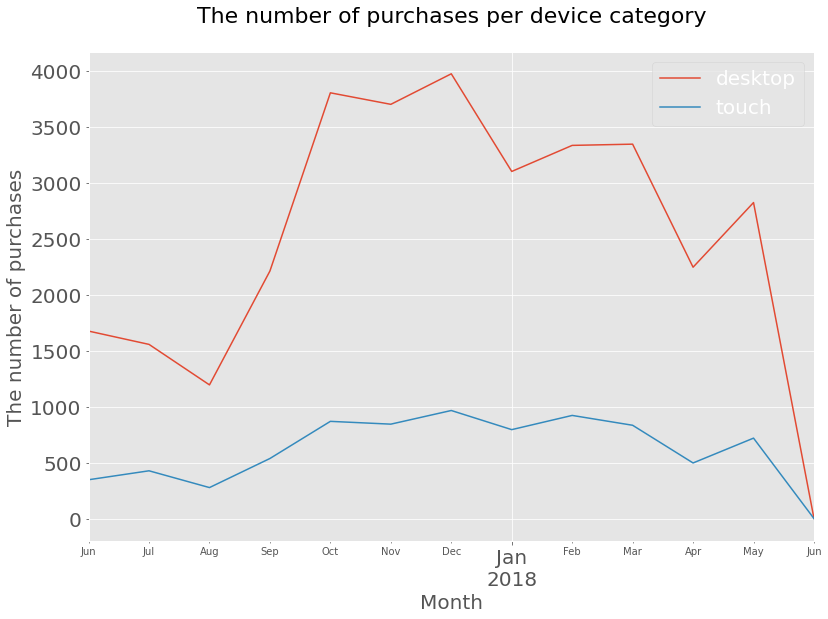

The average number of purchases is 3878
The average number of purchases for desktop is 3146
The average number of purchases for mobile is 792


In [28]:
# purchases per device category
purchases.pivot_table(index='order_month', values='uid', 
                                 columns='device_cat', aggfunc='nunique').\
fillna(0).astype(int).plot(figsize=(13, 9))
plt.title('The number of purchases per device category' + '\n', 
          fontsize=22, c='black')
plt.xlabel('Month', fontsize=20)
plt.ylabel('The number of purchases', fontsize=20)
plt.legend(loc=0, prop={'size': 20})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.show()

# average number of purchases per month
mean_number_of_purchases_by_month = purchases.groupby(
    'order_month')['uid'].count().mean()

# average number of purchases per device category
number_of_purchases_by_month_desktop = purchases.query(
    'device_cat == "desktop"')
mean_number_of_purchases_by_month_desktop = \
number_of_purchases_by_month_desktop.groupby('order_month')['uid'].\
count().mean()
number_of_purchases_by_month_touch = purchases.query(
    'device_cat == "touch"')
mean_number_of_purchases_by_month_touch = number_of_purchases_by_month_touch.\
groupby('order_month')['uid'].count().mean()
print('The average number of purchases is', int(
    mean_number_of_purchases_by_month))
print('The average number of purchases for desktop is', int(
    mean_number_of_purchases_by_month_desktop))
print('The average number of purchases for mobile is', int(
    mean_number_of_purchases_by_month_touch))

In [29]:
# calculating the number of purchases per user

# grouping by uid 
grouping_orders = purchases.groupby('uid')['order_month']

# month of the first purchase
purchases['cohort_month'] = grouping_orders.transform('min')
visit_year, visit_month, _ = get_date_int(purchases, 'order_month')
cohort_year, cohort_month, _ = get_date_int(purchases, 'cohort_month')
year_diff_orders = visit_year - cohort_year
month_diff_orders = visit_month - cohort_month
purchases['cohort_index'] = year_diff_orders * 12 + month_diff_orders
grouping_orders = purchases.groupby(['cohort_month', 'cohort_index'])
cohort_data_orders = grouping_orders['uid'].apply(pd.Series.nunique)
cohort_data_orders = cohort_data_orders.reset_index()
cohort_counts_orders = cohort_data_orders.pivot_table(index='cohort_month', 
                                                      columns='cohort_index', 
                                                     values='uid')
users_by_month = purchases.groupby('order_month').agg({'uid':'nunique'})
users_by_month.name = 'users_by_month'
purchases_by_month = purchases.groupby('order_month').agg({'uid':'count'})
purchases_by_month.name = 'purchases_by_month'
purchases_by_month_mean = purchases_by_month / users_by_month
purchases_by_month_mean.mean()
print('Average number of purchases per user is', float(purchases_by_month_mean.\
                                                     mean().round(2)))

Average number of purchases per user is 1.21


## To sum up:

- the average user makes 1.2 purchases 
- the proportion of purchases desktop / mobile has approximately remained at the level of the proportion of visits.

# What is the average receipt?

The average receipt is 4.999646930476993 thousand roubles


4.999646930476993

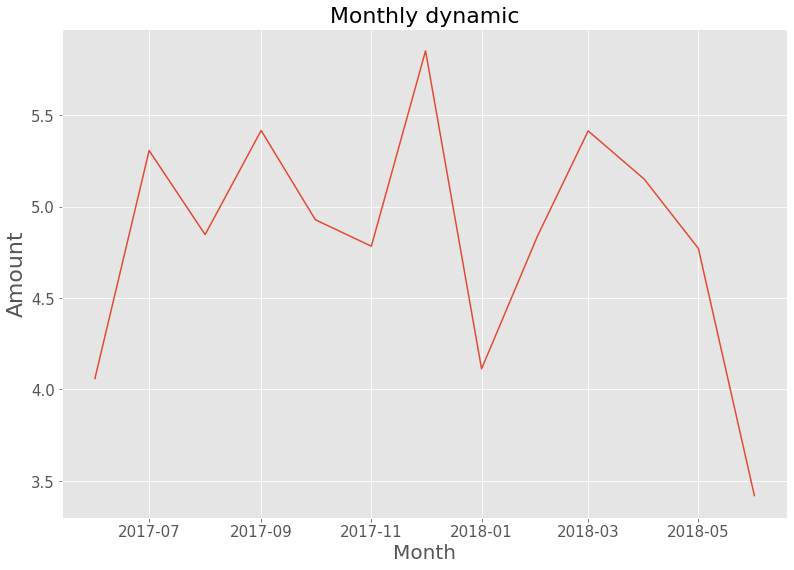

In [30]:
# average receipt
df_orders['month_of_order'] = df_orders['dt_of_order'].astype('datetime64[M]')
print('The average receipt is', float(df_orders['revenue'].mean()), 'thousand roubles')
plt.figure(figsize=(13, 9))
plt.plot(df_orders.pivot_table(index='month_of_order', values='revenue', 
                               aggfunc='mean'))
plt.title('Monthly dynamic', fontsize=22, c='black')
plt.xlabel('Month', fontsize=20)
plt.ylabel('Amount', fontsize=22)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True)
df_orders['revenue'].mean()

## To sum up
The average receipt is 5 thousand rubles.
Observing the average receipt, you can note some seasonality. In December, there is a significant increase (it is possible that people buy gifts), in January it drops sharply, and in March everything returns back to normal.

# How much income do customers bring us? (LTV)


**Since real margin rate is not provided, 1 is going to be used**

  first_order_month  n_buyers order_month  revenue       gp  age   ltv
0        2017-06-01      2023  2017-06-01 9557.490 9557.490    0 4.724


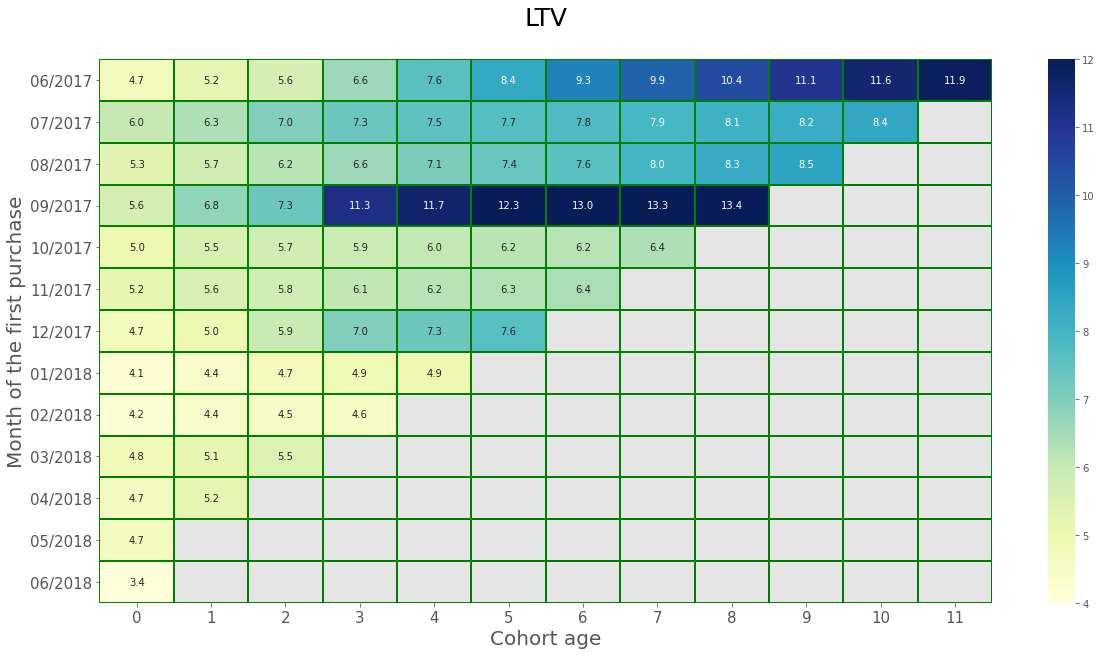

Average LTV for the first 6 months is 7.97 thousand


In [31]:
# посчитаем LTV
df_orders_ltv = df_orders.copy()
def count_ltv(df):
    df['order_month'] = df['dt_of_order'].astype('datetime64[M]')
    first_order = df.groupby('uid').agg({'order_month':'min'}).\
    reset_index()
    first_order.columns = ['uid', 'first_order_month']
    cohort_sizes = first_order.groupby('first_order_month').\
    agg({'uid':'nunique'}).\
    reset_index()
    cohort_sizes.columns = ['first_order_month', 'n_buyers']
    df_new = pd.merge(df,first_order, on='uid')
    cohorts = df_new.groupby(['first_order_month', 'order_month']).\
    agg({'revenue': 'sum'}).reset_index()
    report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
    margin_rate = 1
    report['gp'] = report['revenue'] * margin_rate
    report['age'] = (report['order_month'] - report['first_order_month']) / \
    np.timedelta64(1, 'M')
    report['age'] = report['age'].round().astype('int')
    report['ltv'] = report['gp'] / report['n_buyers']
    return report

report_ltv = count_ltv(df_orders)  
print(report_ltv.head(1)) 


output = report_ltv.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='sum').round(4)
output.fillna('')
output = output.cumsum(axis=1)
output.index = output.index.strftime("%m/%Y")
plt.figure(figsize=(20, 10))
sns.heatmap(output, annot=True, fmt = '.1f', linewidths=1, linecolor='green', 
            cmap="YlGnBu", vmin=4, vmax=12)
plt.ylabel('Month of the first purchase', fontsize=20)
plt.xlabel('Cohort age', fontsize=20)
plt.title('LTV' + '\n', fontsize=25, c='black')
plt.yticks(rotation=0, fontsize=15)
plt.xticks(fontsize=15)
plt.show()

# примим за период жизни клиента 6 месяцев и рассчитаем средний ltv за это время
final_result = report_ltv.pivot_table(index='first_order_month', columns='age',
                                  values='ltv', aggfunc='mean')
m6_cum_ltv = final_result.cumsum(axis=1).mean(axis=0)[5]
print('Average LTV for the first 6 months is', m6_cum_ltv.round(2), 'thousand')
#report_sources = count_ltv(orders_sources)
#print()

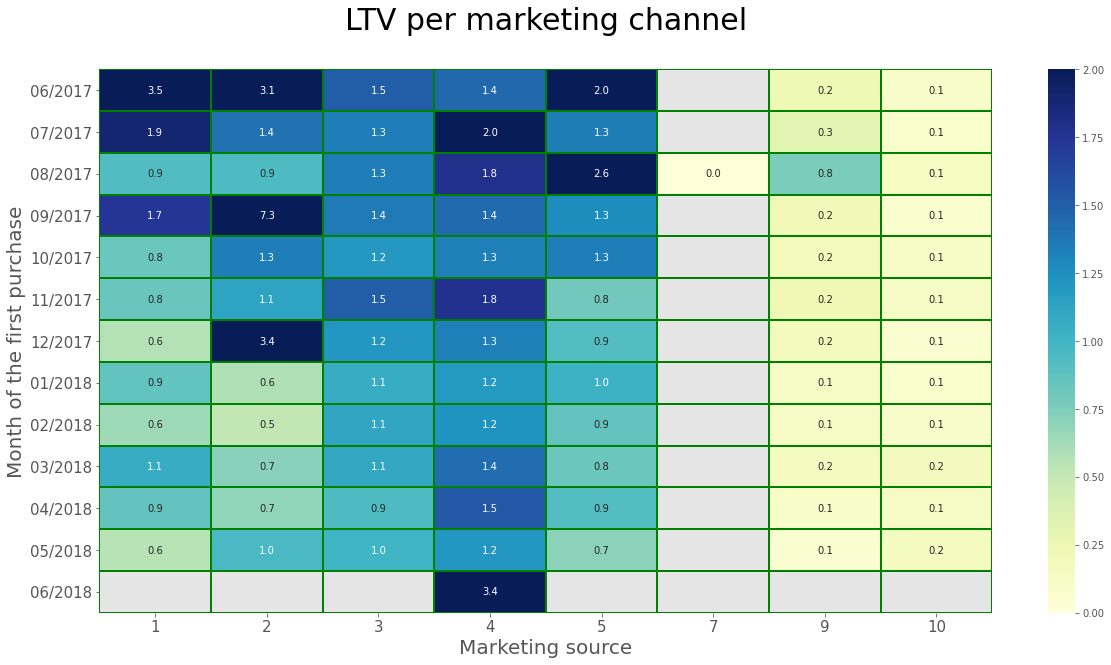

In [32]:
# Let's calculate LTV for marketing channels 
# we are not going to be using the function written before since we need to group data 
# differently

visits_sources = df_visits.groupby('uid')['commercial_source_id'].first().\
reset_index()
df_visits
orders_sources = df_orders.merge(visits_sources, how = 'left', on = 'uid')
orders_sources
orders_sources['order_month'] = orders_sources['dt_of_order'].\
astype('datetime64[M]')
first_order_source = orders_sources.groupby('uid').agg({'order_month': 'min'}).\
reset_index()
first_order_source.columns = ['uid', 'first_order_month']
orders_sources
first_order_source
cohort_sizes = first_order_source.groupby('first_order_month').\
agg({'uid':'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
orders_source_new = pd.merge(orders_sources,first_order_source, on='uid')
cohorts_orders = orders_source_new.groupby(['first_order_month','order_month', 
                                            'commercial_source_id']).\
agg({'revenue': 'sum'}).reset_index()
report_source = pd.merge(cohort_sizes, cohorts_orders, on='first_order_month')
margin_rate = 1
report_source['gp'] = report_source['revenue'] * margin_rate
report_source['ltv'] = report_source['gp'] / report_source['n_buyers']


# визуализируем полученную таблицу 
output_source = report_source.pivot_table(index = 'first_order_month', 
                                          columns = 'commercial_source_id', 
                                          values = 'ltv', aggfunc = 'sum').round(4)
output_source.fillna('')
output_source.index = output_source.index.strftime("%m/%Y")
plt.figure(figsize=(20, 10))
sns.heatmap(output_source, annot=True, fmt = '.1f', linewidths=1, 
            linecolor='green', cmap="YlGnBu", vmin = 0, vmax = 2)
plt.ylabel('Month of the first purchase', fontsize = 20)
plt.xlabel('Marketing source', fontsize = 20)
plt.title('LTV per marketing channel' + '\n', fontsize = 30, c='black')
plt.yticks(rotation = 0, fontsize = 15)
plt.xticks(fontsize = 15)
plt.show()

From this heatmap, it could be seen that the highest LTV is in the markting channels 3 and 4. However, in addition to this, there is an interesting detail. LTV for the second source in September and December is very high. We obviously don't have enough context to understand what this might be related to, but we will pass it on to marketers.

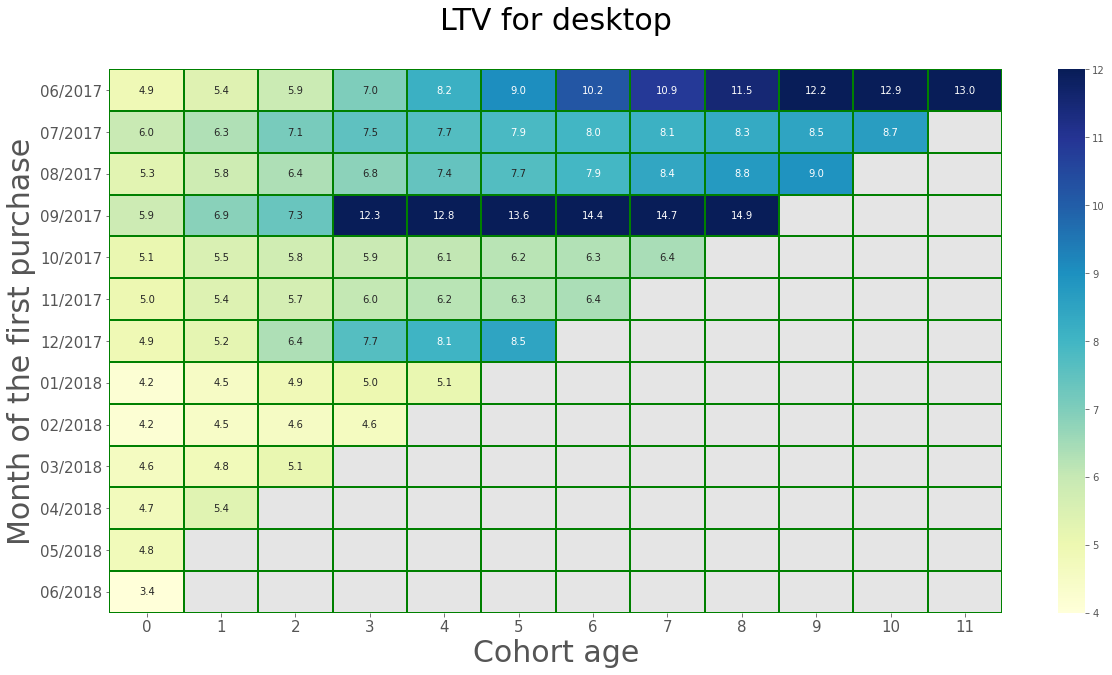

In [33]:
# LTV for desktop

visits_device_category = df_visits.groupby('uid')['device_cat'].first().reset_index()
orders_with_devices_categories = df_orders.merge(visits_device_category, on='uid')
ltv_desktop = orders_with_devices_categories.query('device_cat == "desktop"')
report_desktop = count_ltv(ltv_desktop)
#display(report_desktop.head(1))


desk_output = report_desktop.pivot_table(index='first_order_month', 
                                         columns='age', values='ltv', 
                                         aggfunc='sum').round(4)
desk_output = desk_output.cumsum(axis=1)
desk_output.fillna('')
desk_output
desk_output.index = desk_output.index.strftime("%m/%Y")
plt.figure(figsize=(20, 10))
sns.heatmap(desk_output, annot=True, fmt='.1f', linewidths=1, 
            linecolor='green', cmap="YlGnBu", vmin=4, vmax=12)
plt.ylabel('Month of the first purchase', fontsize=30)
plt.xlabel('Cohort age', fontsize=30)
plt.title('LTV for desktop' + '\n', fontsize=30, c='black')
plt.yticks(rotation=0, fontsize=15)
plt.xticks(fontsize=15)
plt.show() 

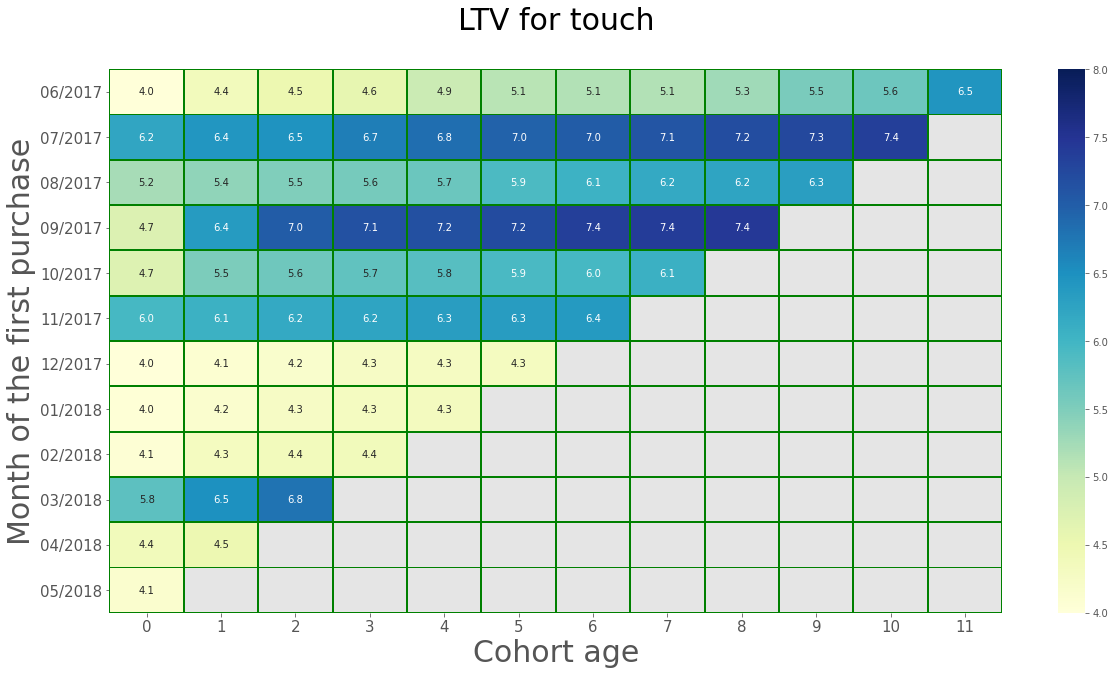

In [34]:
# LTV for mobile 


visits_device_category = df_visits.groupby('uid')['device_cat'].first().reset_index()
ltv_by_devices = df_orders.merge(visits_device_category, on = 'uid')
ltv_touch = orders_with_devices_categories.query('device_cat == "touch"')
ltv_touch['order_month'] = ltv_touch['dt_of_order'].astype('datetime64[M]')
touch_first_order = ltv_touch.groupby('uid').agg({'order_month':'min'}).\
reset_index()
touch_first_order.columns = ['uid','first_order_month']
touch_desktop = ltv_touch.merge(touch_first_order, on = 'uid')
touch_cohort_sizes = touch_first_order.groupby('first_order_month').\
agg({'uid':'nunique'}).reset_index()
touch_cohort_sizes.columns = ['first_order_month', 'n_buyers']
touch_new = pd.merge(ltv_touch, touch_first_order, on = 'uid')
touch_new
touch_cohorts = touch_new.groupby(['first_order_month', 'order_month']).\
agg({'revenue':'sum'}).reset_index()
touch_report = pd.merge(touch_cohort_sizes, touch_cohorts, 
                        on='first_order_month')
margin_rate = 1
touch_report['gp'] = touch_report['revenue'] * margin_rate
touch_report['age'] = (touch_report['order_month'] - 
                       touch_report['first_order_month'])/ np.timedelta64(1, 'M')
touch_report['age'] = touch_report['age'].round().astype('int')
touch_report['ltv'] = touch_report['gp'] / touch_report['n_buyers']

# visualizing 
touch_output = touch_report.pivot_table(index = 'first_order_month', 
columns = 'age', values = 'ltv', aggfunc = 'sum').round(4)
touch_output = touch_output.cumsum(axis = 1)
touch_output.fillna('')
touch_output.index = touch_output.index.strftime('%m/%Y')
plt.figure(figsize = (20,10))
sns.heatmap(touch_output, annot=True, fmt='.1f', linewidths=1, 
            linecolor='green', cmap="YlGnBu", vmin=4, vmax=8)
plt.ylabel('Month of the first purchase', fontsize=30)
plt.xlabel('Cohort age', fontsize=30)
plt.title('LTV for touch' + '\n', fontsize=30, c='black')
plt.yticks(rotation=0, fontsize=15)
plt.xticks(fontsize=15)
plt.show()

desk_output = report_desktop.pivot_table(index='first_order_month', 
                                         columns='age', values='ltv', 
                                         aggfunc='sum').round(4)
desk_output = desk_output.cumsum(axis=1)

## To sum up:

- ltv for desktop is significantly higher, than for mobile 
- average ltv for months is 7.97
- LTV of the second marketing source is surpisingly high in December and September (of course, we also need to check how much money was spent on it during these two months) 

# What are the costs? Overall / per every source / by months

Overall the amount spent on marketing from 2017-06-01 00:00:00 to 2018-05-01 00:00:00 is 329131


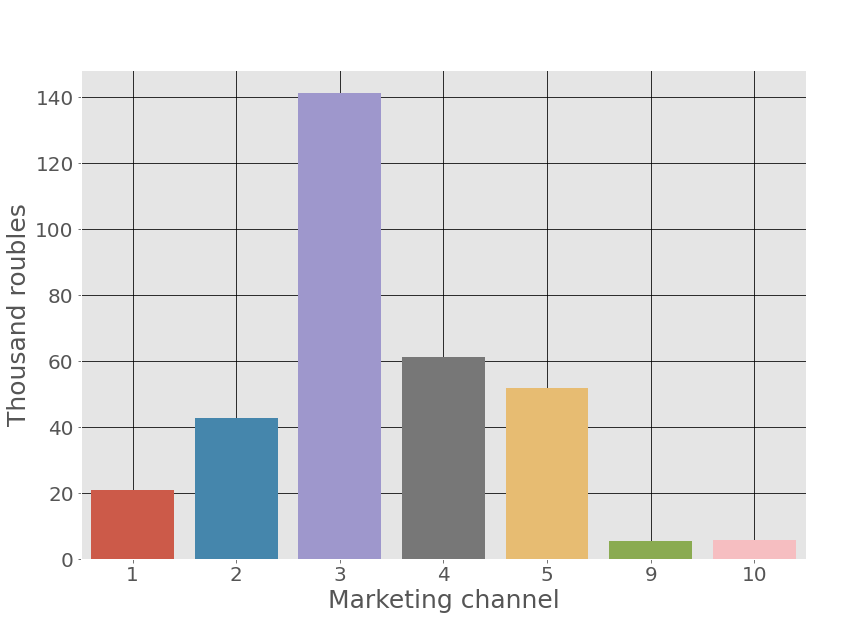

           cost_for_marketing_source
source_id                           
1                             20.833
2                             42.806
3                            141.322
4                             61.074
5                             51.757
9                              5.517
10                             5.822


In [35]:
# how much spent on marketing


print('Overall the amount spent on marketing from', 
      df_costs['month_of_commercial'].\
      min(), 'to', df_costs['month_of_commercial'].max(), 'is',
     int(df_costs['cost_for_marketing_source'].sum()))
df_costs_new = df_costs.copy()
df_costs_new.source_id = pd.Categorical(df_costs_new.source_id)
pivot_costs_sources_sum_new = df_costs_new.pivot_table(index='source_id', 
                                                       values='cost_for_marketing_source', 
                                                       aggfunc='sum')
pivot_costs_sources_sum_new['cost_for_marketing_source'] = \
pivot_costs_sources_sum_new['cost_for_marketing_source'] / 1000
plt.figure(figsize=(13, 9))
sns.barplot(x=pivot_costs_sources_sum_new.index, y='cost_for_marketing_source', 
            data=pivot_costs_sources_sum_new)
plt.title('Overall expenses on marketing per  marketing channel' + '\n', fontsize=30)
plt.xlabel('Marketing channel', fontsize=25)
plt.ylabel('Thousand roubles', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(c='black')
plt.show()
print(pivot_costs_sources_sum_new)

In [36]:
# Let's see if the product is profitable 
print('Total revenue is', 
      int(df_orders['revenue'].sum()))

Total revenue is 252057


### The product is loosing money (or hasn't become profitable yet).

let's check how much money was spent on marketing monthly

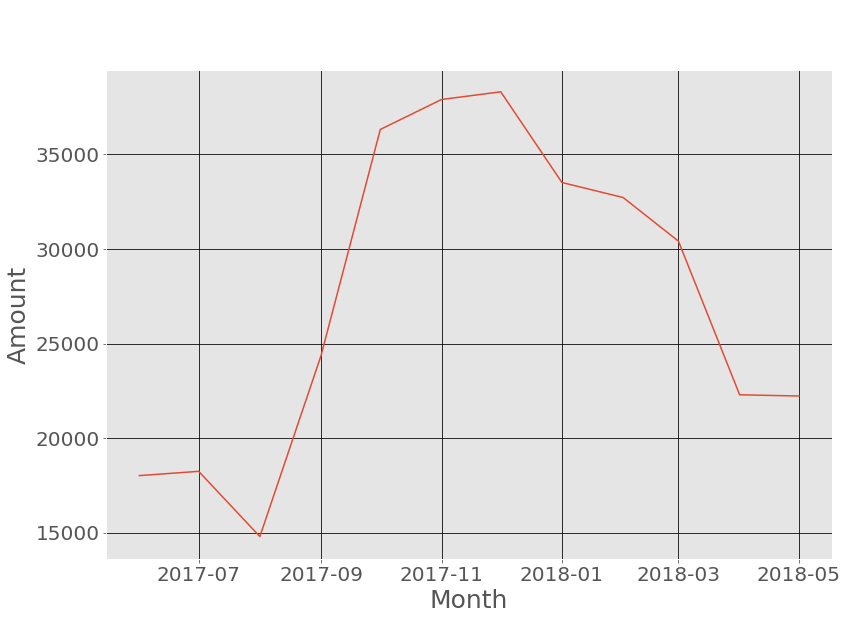

Average amount spent on marketing monthly 27427


In [37]:
plt.figure(figsize=(13,9))
plt.plot(df_costs.groupby('month_of_commercial')['cost_for_marketing_source'].sum())
plt.title('Monthly marketing costs' + '\n', fontsize=30)
plt.xlabel('Month', fontsize=25)
plt.ylabel('Amount', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(c='black')
plt.show()
print('Average amount spent on marketing monthly', int(
            df_costs.groupby('month_of_commercial')['cost_for_marketing_source'].\
                                               sum().mean()))

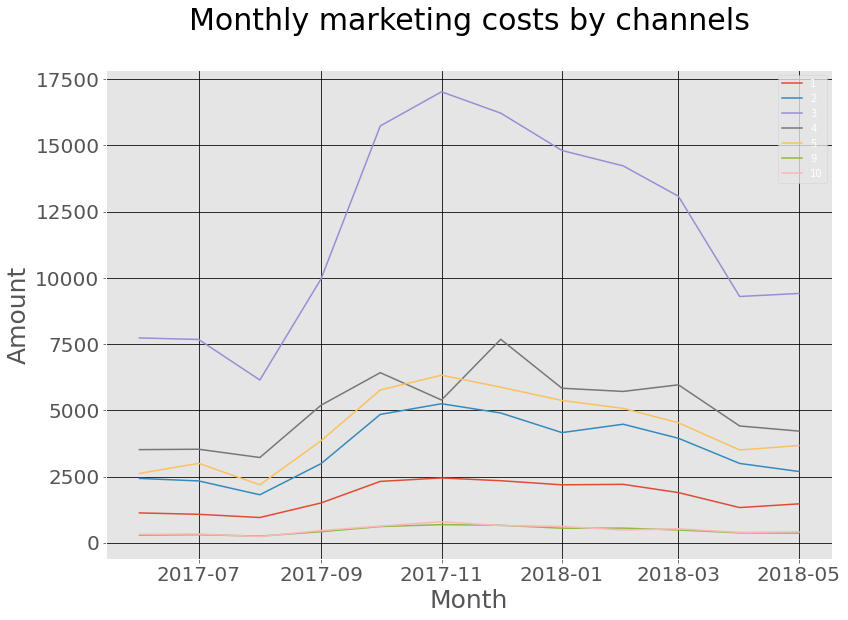

In [38]:
costs_pivot = df_costs.pivot_table(index='month_of_commercial', 
                                   values='cost_for_marketing_source', 
                                   columns='source_id', aggfunc='sum')
plt.figure(figsize=(13,9))
plt.plot(costs_pivot)
plt.legend(costs_pivot.columns)
plt.title('Monthly marketing costs by channels' + '\n', fontsize=30,
         color='black')
plt.xlabel('Month', fontsize=25)
plt.ylabel('Amount', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(c='black')
plt.show()

## To sum up:
- for almost a year, 329131 rubles were spent on marketing, and a total of 252057 was earned - the project is unprofitable yet or unprofitable at all (depending on how many months a customer lives) 
- our most expensive marketing channel is the third one, it took 141 thousand rubles, and the fourth (another channel that brings us a comparable number of site visits) - 61 thousand. It is possible that one of the reasons for the commercial failure of our product is that marketing money is invested in the wrong place. Perhaps we need to invest more money in the fourth and fifth marketing channels. 
- monthly average cost on marketing is 27427

# Customer acquisition cost. 

In [39]:
# calculating CAC 

display(df_costs.head(2))
display(df_orders.head(2))
marketing_sources = df_visits.groupby('uid')['commercial_source_id'].first().reset_index()
orders_with_marketing_sources = df_orders.merge(marketing_sources, on='uid', how='left')
orders_with_sources = pd.merge(orders_with_marketing_sources, df_orders, on=['uid', 
                                                                'dt_of_order', 'revenue'], 
                               how='right')
orders_with_sources
cost_per_source = df_costs.groupby('source_id')['cost_for_marketing_source'].sum().reset_index()
number_of_clients_per_source = orders_with_marketing_sources.\
groupby('commercial_source_id')['uid'].count().reset_index()
number_of_clients_per_source
cost_per_client = cost_per_source.merge(number_of_clients_per_source, left_on='source_id', 
                                        right_on='commercial_source_id', how='left')
cost_per_client['cost_per_client'] = (cost_per_client['cost_for_marketing_source'] / 
                                      cost_per_client['uid'])
print('CAC per marketing channel')
display(cost_per_client[['commercial_source_id', 'cost_per_client']])
print('Average CAC is', 
      round(cost_per_client['cost_per_client'].mean(), 2), 'thousand roubles')

,source_id,dt_of_commercial,cost_for_marketing_source,day_of_commercial,week_of_commercial,month_of_commercial,year_of_commercial
0,1,2017-06-01,75.200,2017-06-01,2017-06-01,2017-06-01,2017-01-01
1,1,2017-06-02,62.250,2017-06-02,2017-06-01,2017-06-01,2017-01-01


,dt_of_order,revenue,uid,month_of_order,order_month
0,2017-06-01 00:10:00,17.000,10329302124590727494,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.550,11627257723692907447,2017-06-01,2017-06-01


CAC per marketing channel


,commercial_source_id,cost_per_client
0,1,3.119
1,2,5.535
2,3,12.917
3,4,4.987
4,5,5.559
5,9,2.688
6,10,4.013


Average CAC is 5.55 thousand roubles


## To sum up:
**Average CAC is 5.55 thousand roubles. Six months LTV - 7.97, our product can still be profitable.** 

# How much did the expenses pay off? (ROI, ROMI)

Average LTV for 6 months: 7.969052630207336


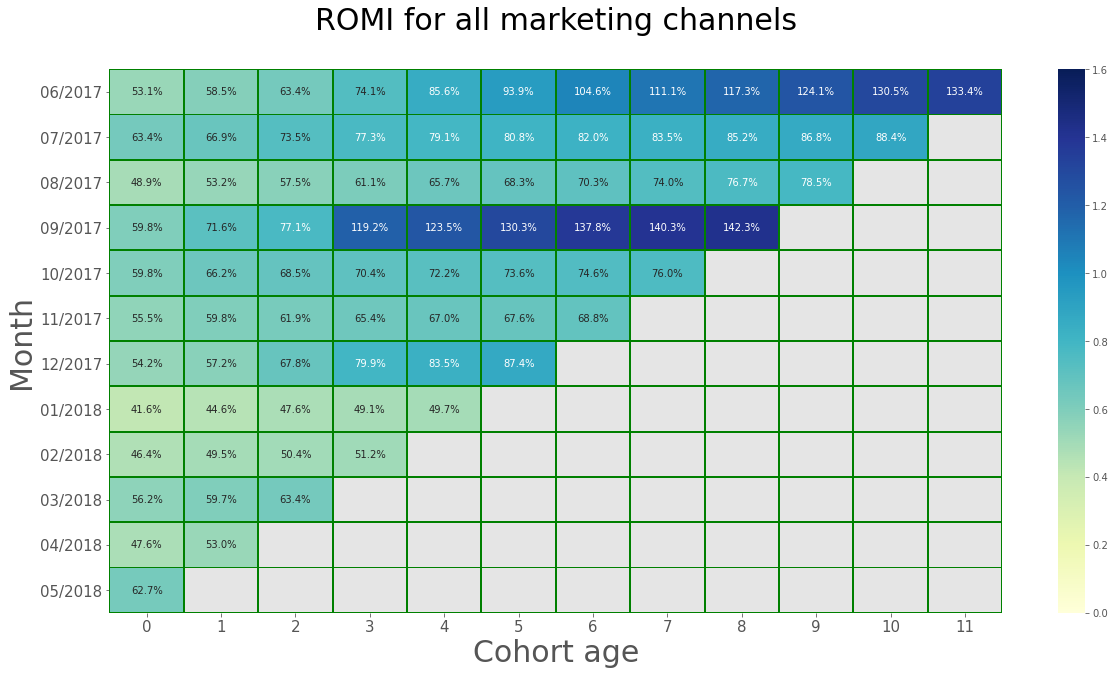

In [40]:
#ROMI for all channels

monthly_costs = df_costs.groupby('month_of_commercial').sum()
monthly_costs
report_new = pd.merge(report_ltv, monthly_costs, left_on = 'first_order_month', 
                      right_on = 'month_of_commercial')
report_new['cac'] = report_new['cost_for_marketing_source'] / report_new['n_buyers']
report_new['romi'] = report_new['ltv'] / report_new['cac']
output_mark = report_new.pivot_table(index='first_order_month', columns='age', 
                                     values='romi', aggfunc='mean')
print('Average LTV for 6 months:', m6_cum_ltv)
output_mark = output_mark.cumsum(axis=1)
output_mark.index = output_mark.index.strftime("%m/%Y")
plt.figure(figsize=(20, 10))
sns.heatmap(output_mark, fmt='.1%', annot=True, linewidths=1, linecolor='green',
            cmap="YlGnBu", vmin=0, vmax=1.6)
plt.ylabel('Month', fontsize=30)
plt.xlabel('Cohort age', fontsize=30)
plt.title('ROMI for all marketing channels' + '\n', fontsize=30, color='black')
plt.yticks(rotation=0, fontsize=15)
plt.xticks(fontsize=15)
plt.show()

#m6_cum_ltv = final_result.cumsum(axis=1).mean(axis=0)[5]
#m6_cum_ltv


Looking at the data, we can see that the distribution of our real ROMI was strongly influenced by the unusual metric values that the 1st and 4th cohorts demonstrated. Therefore, it is important to realize that the real ROMI of most cohorts in our data will be lower.

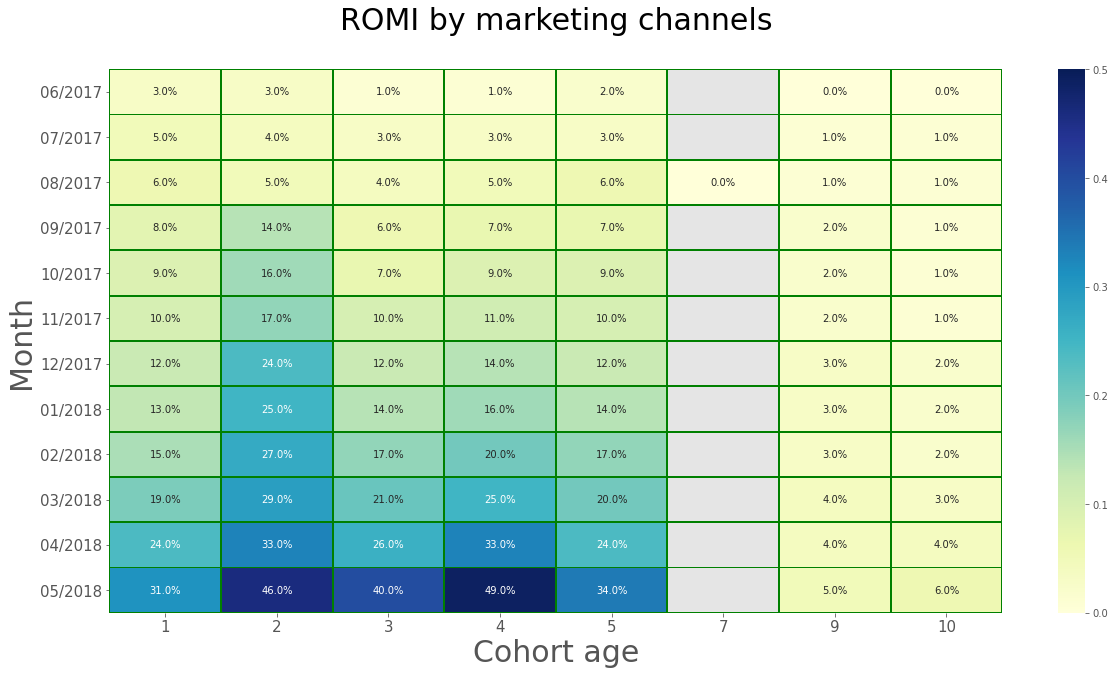

In [41]:
costs_sources = df_costs.groupby('month_of_commercial').sum()
report_source_new = pd.merge(report_source, costs_sources, left_on='first_order_month',
                             right_on='month_of_commercial')
report_source_new['cac'] = (report_source_new['cost_for_marketing_source'] / 
                            report_source_new['n_buyers'])
report_source_new['romi'] = report_source_new['ltv'] / report_source_new['cac']
output_source = report_source_new.pivot_table(index='first_order_month', 
                                              columns='commercial_source_id', values='romi',
                                              aggfunc='mean')
output_source = output_source.cumsum(axis = 0).round(2)
output_source.fillna('')
#print(output_source)
output_source.index = output_source.index.strftime("%m/%Y")
plt.figure(figsize=(20, 10))
sns.heatmap(output_source, fmt='.1%', annot=True, linewidths=1, linecolor='green', 
            cmap="YlGnBu", vmin=0, vmax=0.5)
plt.ylabel('Month', fontsize=30)
plt.xlabel('Cohort age', fontsize=30)
plt.title('ROMI by marketing channels' + '\n', fontsize=30, color='black')
plt.yticks(rotation=0, fontsize=15)
plt.xticks(fontsize=15)
plt.show()

## To sum up: 
- there are several flaws with the payback of cohorts - only two, the first and fourth, paid off
- the marketing pays off badly, the most promising channel is 4. Even it paid off only by 49 %.
- it is necessary either to change the advertising itself, or to look for new marketing opportunities

# To conclude:

We analyzed Yandex. Afisha's visits, sales, and costs. The product has seasonality. People significantly increase purchases in November and December. It turned out that the product is unprofitable yet. Despite the fact that our product has a fairly high retention rate (4.6%) if we draw conclusions from the available data, it can not yet bring us profit.

Nevertheless, it is clear from the study that we have several points of potential growth.

First, it is the development of a convenient mobile application(or improvement of the current one). At the moment, the mobile version of Yandex Billboard is used by only 1/4 of all users. Given this, making purchases with the development of technologies like apple pay has become much easier, we can assume that sales of Ya. Afisha will go up if we attract more users to visit the site from a mobile device.

Secondly, we spend a lot of money on the third marketing channel. Its ROMI is only 40 %, which is catastrophically small. But in general, if we talk about marketing, ROMI does not exceed 50% at any channel. This indicates either poorly designed advertising, or the coverage of these channels by the wrong users whose problems our product should solve.

At the moment, the most promising channel looks 4, but it also has a payback of only 49%.


P.S. the data was provided by Yandex during the bootcamp